In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from maxentropy.skmaxent import MinDivergenceModel

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Average, MaxPooling1D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from PIL import Image, ImageFile

from tensorflow.keras import backend as K
from tqdm import tqdm

#This is to handle corrupted images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
#Setting data path
data_dir = os.path.join('..', 'data', 'scored')
labels_dir = os.path.join('..', 'data', 'scored.csv')
test_dir = os.path.join('..', 'data', 'query')

#This is used later with the batch size
num_train_imgs = len(os.listdir(data_dir))
num_test_imgs = len(os.listdir(test_dir))

#Just checking that no images are lost on the way
print("number of training images: ", num_train_imgs)
print("number of test images: ", num_test_imgs)

eval_df = pd.read_csv(os.path.join('..', 'data', 'query_example.csv'))
eval_df['Id'] = eval_df['Id'].astype(str)+'.png'

#Getting the indices in order of appearance from the directory and adding png for the generator
scores_df = pd.read_csv(labels_dir)
scores_df.reset_index(drop=True, inplace=True)
scores_df = scores_df.sort_values(by=['Id'])
scores_df['Id'] = scores_df['Id'].astype(str)+'.png'
eval_df

number of training images:  9600
number of test images:  1200


,Id,Predicted
0,7452475.png,0.0
1,7071865.png,0.0
2,9302616.png,0.0
3,7562317.png,0.0
4,5940084.png,0.0
...,...,...
1195,9022030.png,0.0
1196,2640528.png,0.0
1197,1114602.png,0.0
1198,6934039.png,0.0


In [22]:
#Setting parameters
batch_size = 64
epochs = 25
IMG_HEIGHT = 150
IMG_WIDTH = 150
conv_layer_sizes = [16,32,64]
dense_layer_size = 10
dropout=0.2
l2_reg=0.01
val_split = 0.25
learning_rate = 1e-3
batch_norm=True

In [4]:
#scaling values to get intensity between 0 and 1
train_image_generator = ImageDataGenerator(rescale=1./255, validation_split=val_split) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [5]:
#Generator for our training data, it's being pulled from the dataframe
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=scores_df, directory=data_dir, 
                                              x_col="Id", y_col="Actual", has_ext=True, 
                                              class_mode="other", target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=1, subset='training')

test_data_gen = train_image_generator.flow_from_dataframe(dataframe=scores_df, directory=data_dir, 
                                              x_col="Id", y_col="Actual", has_ext=True, 
                                              class_mode="other", target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=1, subset='validation')

full_train_data_gen = train_image_generator.flow_from_dataframe(dataframe=scores_df, directory=data_dir, 
                                              x_col="Id", y_col="Actual", has_ext=True, 
                                              class_mode="other", target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=1)

Found 7200 validated image filenames.
Found 2400 validated image filenames.
Found 9600 validated image filenames.


In [6]:
def get_features():
    def f0(x):
        return x

    return [f0]

In [42]:
def get_max_entropy_distribution(mean):
    SAMPLESPACE = np.arange(8)
    features = get_features()

    model = MinDivergenceModel(features, samplespace=SAMPLESPACE, algorithm='CG')

    # set the desired feature expectations and fit the model
    X = np.array([mean])
    model.fit(X)

    return model.probdist()

In [8]:
X_train = np.empty([len(train_data_gen), IMG_HEIGHT, IMG_WIDTH,3])
y_train = np.empty([len(train_data_gen),8])

for i in tqdm(range(len(train_data_gen))):
    (x,y) = train_data_gen[i]
    X_train[i] = x
    y_train[i] = get_max_entropy_distribution(y.reshape(-1)).tolist()
    
y_train

100%|█████████████████████████████████████████████████████████████████████████████| 7200/7200 [01:09<00:00, 102.99it/s]


array([[2.91572413e-01, 2.13613932e-01, 1.56499414e-01, ...,
        6.15406592e-02, 4.50863716e-02, 3.30315101e-02],
       [1.48720947e-01, 1.41235577e-01, 1.34126957e-01, ...,
        1.14876703e-01, 1.09094768e-01, 1.03603848e-01],
       [9.99494606e-01, 5.05139041e-04, 2.55294475e-07, ...,
        3.29558758e-17, 1.66557172e-20, 8.41770726e-24],
       ...,
       [9.98996258e-01, 1.00273476e-03, 1.00648725e-06, ...,
        1.01782919e-15, 1.02163817e-18, 1.02546141e-21],
       [2.25274546e-01, 1.85043603e-01, 1.51997354e-01, ...,
        8.42406841e-02, 6.91964536e-02, 5.68389163e-02],
       [9.99489696e-01, 5.10043711e-04, 2.60277408e-07, ...,
        3.45878607e-17, 1.76503279e-20, 9.00703505e-24]])

In [44]:
X_train_full = np.empty([len(full_train_data_gen), IMG_HEIGHT, IMG_WIDTH,3])
y_train_full = np.empty([len(full_train_data_gen),8])

for i in tqdm(range(len(full_train_data_gen))):
    (x,y) = full_train_data_gen[i]
    X_train_full[i] = x
    y_train_full[i] = get_max_entropy_distribution(y.reshape(-1)).tolist()
    
y_train_full

100%|██████████████████████████████████████████████████████████████████████████████| 9600/9600 [04:20<00:00, 36.87it/s]


array([[0.36013029, 0.23464955, 0.15289025, ..., 0.04229217, 0.02755625,
        0.01795478],
       [0.30497011, 0.21839645, 0.15639897, ..., 0.05743793, 0.04113269,
        0.02945611],
       [0.37587729, 0.23827822, 0.15105065, ..., 0.03848021, 0.02439359,
        0.01546372],
       ...,
       [0.37918521, 0.23898338, 0.15062047, ..., 0.03770795, 0.02376562,
        0.0149784 ],
       [0.33264413, 0.22724009, 0.15523515, ..., 0.04948862, 0.0338073 ,
        0.02309487],
       [0.31590901, 0.22205844, 0.1560891 , ..., 0.05421112, 0.03810603,
        0.02678545]])

In [57]:
(x,y) = full_train_data_gen[10]
print(y)
print(mean_score(y_train_full[10]))

[2.49079286]
3.490792868516544


In [37]:
X_test = np.empty([len(test_data_gen), IMG_HEIGHT, IMG_WIDTH,3])

for i in tqdm(range(len(test_data_gen))):
    (x,y) = test_data_gen[i]
    X_test[i] = x
    

100%|██████████████████████████████████████████████████████████████████████████████| 2400/2400 [00:28<00:00, 83.67it/s]


In [10]:
#Generator for our query
val_data_gen = validation_image_generator.flow_from_dataframe(batch_size=1, dataframe=eval_df, x_col="Id",
                                                              directory=test_dir, y_col='Predicted', class_mode='other',
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1200 validated image filenames.


In [25]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
conv = inputs

for dim in conv_layer_sizes:
    conv = Conv2D(dim, 3,padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3) ) (conv)
    conv = MaxPooling2D()(conv)
    if batch_norm:
        conv=BatchNormalization()(conv)
    conv=Dropout(dropout)(conv)
    
conv=Flatten()(conv)
conv=Dense(dense_layer_size, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(conv)
if batch_norm:
    conv=BatchNormalization()(conv)
conv=Dropout(dropout)(conv)
conv=Dense(8, activation='softmax')(conv)
#conv=tf.math.reduce_mean(conv, keepdims=False)
#conv=Dense(1)(conv)

model = tf.keras.Model(inputs=inputs, outputs=conv)

In [12]:
def earth_mover_loss(y_true, y_pred):
    cdf_ytrue = K.cumsum(y_true, axis=-1)
    cdf_ypred = K.cumsum(y_pred, axis=-1)
    samplewise_emd = K.sqrt(K.mean(K.square(K.abs(cdf_ytrue - cdf_ypred)), axis=-1))
    return K.mean(samplewise_emd)

In [26]:
opt = optimizers.Adam(learning_rate)
model.compile(loss=earth_mover_loss, optimizer=opt, metrics=['MAE'])

In [52]:
#Training
history = model.fit(
    x=X_train, y=y_train,
    batch_size=batch_size,
    verbose=1,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Train on 7200 samples, validate on 2400 samples
Epoch 1/25
7200/7200 [==============================] - 8s 1ms/sample - loss: 0.1070 - MAE: 0.0348 - val_loss: 0.2911 - val_MAE: 0.1365
Epoch 2/25
7200/7200 [==============================] - 7s 911us/sample - loss: 0.1052 - MAE: 0.0338 - val_loss: 0.2904 - val_MAE: 0.1294
Epoch 3/25
7200/7200 [==============================] - 7s 926us/sample - loss: 0.1056 - MAE: 0.0335 - val_loss: 0.2074 - val_MAE: 0.0808
Epoch 4/25
7200/7200 [==============================] - 7s 914us/sample - loss: 0.1059 - MAE: 0.0337 - val_loss: 0.2345 - val_MAE: 0.0978
Epoch 5/25
7200/7200 [==============================] - 7s 920us/sample - loss: 0.1055 - MAE: 0.0336 - val_loss: 0.2826 - val_MAE: 0.1271
Epoch 6/25
7200/7200 [==============================] - 7s 927us/sample - loss: 0.1052 - MAE: 0.0334 - val_loss: 0.1975 - val_MAE: 0.0637
Epoch 7/25
7200/7200 [==============================] - 7s 929us/sample - loss: 0.1055 - MAE: 0.0340 - val_loss: 0.2485 - val_

In [58]:
def normalize_labels(labels):
    labels_np = np.array(labels)
    return labels_np / labels_np.sum()

def mean_score(scores):
    score_dist = normalize_labels(scores)
    si = np.arange(1,9,1)
    mean = np.sum(score_dist * si)
    return mean

def std_score(scores):
    si = np.arange(1, 9, 1)
    mean = mean_score(scores)
    std = np.sqrt(np.sum(((si - mean) ** 2) * scores))
    return std

In [50]:
#Full Training
history = model.fit(
    x=X_train_full, y=y_train_full,
    batch_size=batch_size,
    verbose=1,
    epochs=epochs
)

Train on 9600 samples
Epoch 1/25
9600/9600 [==============================] - 7s 731us/sample - loss: 0.1130 - MAE: 0.0360
Epoch 2/25
9600/9600 [==============================] - 7s 723us/sample - loss: 0.1126 - MAE: 0.0366
Epoch 3/25
9600/9600 [==============================] - 7s 759us/sample - loss: 0.1138 - MAE: 0.0358
Epoch 4/25
9600/9600 [==============================] - 7s 736us/sample - loss: 0.1126 - MAE: 0.0356s - loss: 0.1131 - MAE
Epoch 5/25
9600/9600 [==============================] - 7s 735us/sample - loss: 0.1133 - MAE: 0.0357
Epoch 6/25
9600/9600 [==============================] - 7s 734us/sample - loss: 0.1142 - MAE: 0.0356
Epoch 7/25
9600/9600 [==============================] - 7s 734us/sample - loss: 0.1152 - MAE: 0.0355
Epoch 8/25
9600/9600 [==============================] - 7s 756us/sample - loss: 0.1137 - MAE: 0.0360
Epoch 9/25
9600/9600 [==============================] - 7s 770us/sample - loss: 0.1159 - MAE: 0.0361
Epoch 10/25
9600/9600 [========================

In [59]:
predictions = ([])

for i in tqdm(range(len(val_data_gen))):
    (img,y) = val_data_gen[i]
    scores = model.predict(img)
    mean = mean_score(scores)
    predictions.append(mean)

predictions

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [01:30<00:00, 13.21it/s]


[1.8623575679957867,
 1.8402795507572591,
 1.7026935713365674,
 1.7503558876924217,
 1.0518509932007873,
 1.534326758934185,
 1.7769226473756135,
 1.833818367216736,
 1.8446799060329795,
 1.1664725069131237,
 1.711368128657341,
 1.8125229929573834,
 1.213446576235583,
 1.802024845033884,
 1.770303383935243,
 1.0555896355108416,
 1.7420764951966703,
 1.8579141199588776,
 1.8013196885585785,
 1.9309397591277957,
 1.7897538775578141,
 1.9394870987161994,
 1.7510600378736854,
 1.9398876568302512,
 1.7657194859348238,
 1.8507649232633412,
 1.629566584713757,
 1.731598713900894,
 1.737162608653307,
 1.8153289956972003,
 1.046061422493949,
 1.0560412504855776,
 1.805867009330541,
 1.768576726783067,
 1.7461524088867009,
 1.5829337271861732,
 1.793205929454416,
 1.7217053603380919,
 1.7521823304705322,
 1.587674284586683,
 1.7577897091396153,
 1.0456000620142731,
 1.8323636897839606,
 1.7698310292325914,
 1.7261747219599783,
 1.773936603218317,
 1.723058093804866,
 1.7533746999688447,
 1.74307

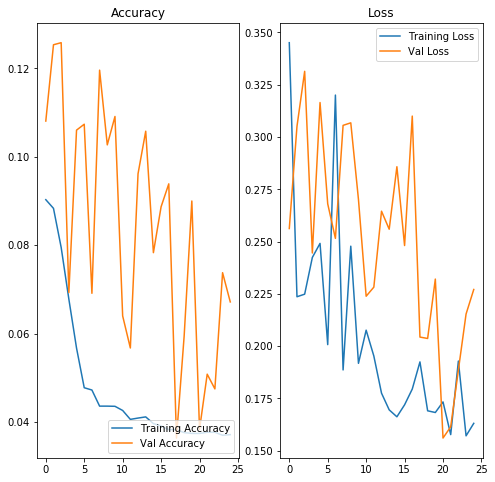

In [18]:
#Pulling some pretty graphs for training

acc = history.history['MAE']

loss=history.history['loss']

val_acc = history.history['val_MAE']

val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [19]:
#Putting predictions in a pretty dataframe
#predictions_file_ids = [x.replace('.png', '') for x in os.listdir(os.path.join(test_dir,'query'))]
results = {'Id': eval_df['Id'], 'Predicted': predictions}
results['Id'] = results['Id'].str[:-4]
results = pd.DataFrame(data=results)
results.to_csv('out_NIMA.csv', index=False)
results


,Id,Predicted
0,7452475,1.729576
1,7071865,1.747626
2,9302616,1.814888
3,7562317,1.808281
4,5940084,1.010314
...,...,...
1195,9022030,1.765172
1196,2640528,1.676711
1197,1114602,1.635304
1198,6934039,1.760017
